In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from tqdm import tqdm  # For progress bars

# Optional: For numerical ODE integration
from scipy.integrate import solve_ivp

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [24]:
to_tensor = lambda lst: torch.tensor(lst, dtype=torch.float32)

# x, y = np.random.rand(2)
x, y = 1.0, 1.0
target_point = to_tensor([x, y])
print("target point: ", target_point)

target point:  tensor([1., 1.])


In [27]:
def interpolate(x0, x1, t, sigma):
    # t is the flow parameter
    mu_t = (1 - t) * x0 + t * x1
    return torch.distributions.Normal(mu_t, sigma)

# Get the interpolated distribution
dist = interpolate(target_point, to_tensor([2,2]), t=0.3, sigma=0.1)
print("Mean:", dist.mean)
print("Std Dev:", dist.stddev)

# Sample from the distribution
sample = dist.sample()
print("Sample:", sample)

Mean: tensor([1.3000, 1.3000])
Std Dev: tensor([0.1000, 0.1000])
Sample: tensor([1.1601, 1.3403])


In [12]:
def vector_field(x0, x1):
    return x1 - x0


In [ ]:
# Simple neural network to learn the vector field v(t, x)
class VectorFieldNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 64),  # input: (x1, x2, t)
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)   # output: vector direction in 2D
        )

    def forward(self, x, t):
        t = t.view(-1, 1)  # ensure t is (batch_size, 1)
        inp = torch.cat([x, t], dim=1)  # concatenate x and t
        return self.model(inp)


In [ ]:
# Instantiate the model and optimizer
model = VectorFieldNet()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training settings
epochs = 1000
batch_size = 128
sigma = 0.1  # noise level

# Training loop
for epoch in range(epochs):
    # Simulating sampling 128 points from a large 2D dataset 
    x0 = torch.randn(batch_size, 2)
    t = torch.rand(batch_size, 1)

    # Linear interpolation with noise to simulate intermediate state
    xt = (1 - t) * x0 + t * target_point  # broadcasts naturally

    # Ground truth vector field: direction from x0 to target_point
    ut = (target_point - x0)  # shape (batch_size, 2)

    # Predict vector field using the model
    vt = model(xt, t)

    # Mean squared error loss
    loss = ((vt - ut) ** 2).mean()

    # backward pass and update
    optimizer.zero_grad()   # clear gradients
    loss.backward()         # compute gradients
    optimizer.step()        # update model parameters

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 1.7389
Epoch 100, Loss: 0.2643
Epoch 200, Loss: 0.1758
Epoch 300, Loss: 0.1951
Epoch 400, Loss: 0.1241
Epoch 500, Loss: 0.1626
Epoch 600, Loss: 0.1156
Epoch 700, Loss: 0.1619
Epoch 800, Loss: 0.1895
Epoch 900, Loss: 0.1609


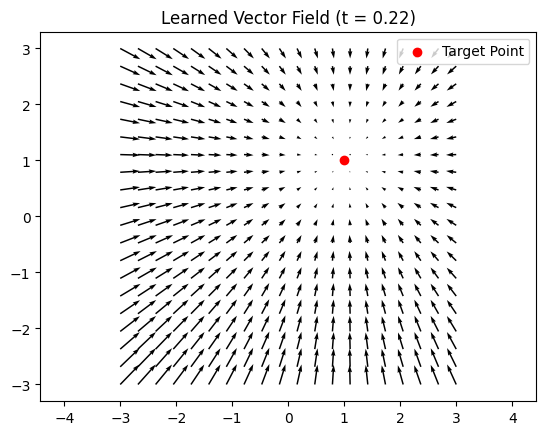

In [ ]:
t = 0.5 # fixed time t

# Visualize learned vector field on a grid
grid_x, grid_y = torch.meshgrid(torch.linspace(-3, 3, 20), torch.linspace(-3, 3, 20), indexing="xy")
grid_points = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)
t_vis = torch.ones(grid_points.shape[0]) * t
with torch.no_grad():
    vectors = model(grid_points, t_vis)

plt.quiver(grid_points[:, 0], grid_points[:, 1], vectors[:, 0], vectors[:, 1])
plt.scatter(target_point[0], target_point[1], color='red', label='Target Point')
plt.title(f"Learned Vector Field (t = {t})")
plt.axis('equal')
plt.legend()
plt.show()